# Here I implement Radial Basis Function Networks

In [23]:
# This is taken from 
# http://www.rueckstiess.net/research/snippets/show/72d2363e
# and modified subsequently to allow for the Least Squares algorithm to build the hidden layer.

#from scipy import *
from scipy.linalg import norm, pinv
from matplotlib import pyplot as plt
import numpy as np

class RBF:
     
    def __init__(self, indim, centers, betas, outdim,):
        self.indim = indim
        self.outdim = outdim
        numCenters = len(centers)
        if numCenters != len(betas):
            print 'number of centers and betas must be the same.'
#        self.numCenters = numCenters
        self.numCenters = numCenters
#        self.centers = [random.uniform(-1, 1, indim) for i in xrange(numCenters)]
        self.centers = centers
        self.beta    = betas
#        self.beta = 8
        self.W = np.random.rand(self.numCenters, self.outdim)
         
    def _basisfunc(self, c, d, bval):
        assert len(d) == self.indim
        return np.exp(-1 * norm(bval*(c-d))**2)
      
     
    def _calcAct(self, X):
        # calculate activations of RBFs
#        G = np.zeros((np.array(X).shape[0], self.numCenters), float)
        G = np.zeros([len(X), self.numCenters])
        for ci, c in enumerate(self.centers):
            beta_ci = self.beta[ci]
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x, beta_ci)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1
            idx: indices of training set objects acting as prototypes """
         
        # choose random center vectors from training set
        #rnd_idx = random.permutation(X.shape[0])[:self.numCenters]
        #self.centers = [X[i,:] for i in rnd_idx]
        #self.centers = [X[i,:] for i in idx] 
        #print "center", self.centers
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print G
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y
 
 


In [24]:
#load databases
#DataDir = './data/'
DataDir = '.'
import pickle
dset = pickle.load(open('%s/training_full.data'%DataDir))

dset_original = dset.copy()

print dset.keys()

featnames = ['dm_j0660','J0378','J0395','J0410','J0430','J0515',
             'J0660','J0861','uSDSS','gSDSS','rSDSS','iSDSS','zSDSS']

ntrain = len(dset['obj'])

['rSDSS', 'iSDSS', 'obj', 'gSDSS', 'J0395', 'zSDSS', 'J0378', 'J0430', 'uSDSS', 'dm_j0660', 'J0660', 'J0410', 'J0515', 'J0861', 'class']


In [25]:
# keeping a fraction away for later validation

def split_trainset(data, test_frac=0.2):
    
    new_train = {}
    test_set = {}
    for k in data.keys():
        test_set[k] = [] # initialize every key as an empty list
        new_train[k] = []
        
    classes = np.unique(data['class'])
    for ic in classes:
        sel = np.where(data['class'] == ic)[0]
        nsel = len(sel)
        ntest = int(nsel*test_frac)
        ntrain = nsel - ntest
        perm = np.random.permutation(sel)
        id_test = perm[0:ntest]
        id_train = perm[ntest:]
        for k in test_set.keys():
            for jd in id_test:
                test_set[k].append(data[k][jd])
            for jd in id_train:
                new_train[k].append(data[k][jd])
                
                
    for k in test_set.keys():
        test_set[k] = np.array(test_set[k]) # Turn lists into arrays
        new_train[k] = np.array(new_train[k])
    return test_set, new_train


In [26]:
test_set, new_train = split_trainset(dset, test_frac = 0.2)

print len(test_set['obj'])
print len(new_train['obj'])
print len(dset['obj'])


149
602
751


In [27]:
ntrain = len(new_train['obj'])
dset = new_train # dset overwritten for consistency

In [54]:
import itertools

def get_features(data):
# Function to generate features from galaxy properties

    featnames = ['dm_j0660','J0378','J0395','J0410','J0430','J0515',
             'J0660','J0861','uSDSS','gSDSS','rSDSS','iSDSS','zSDSS']

    feat_arr = []
    err_arr = []
   
    terms = featnames[1:] # create all colour combinations
    nterms = len(terms)
    ncomb = int(nterms*(nterms-1)/2.)
    print 'All colours:', ncomb
    comb = list(itertools.combinations(terms,2))
    lcomb = list(comb)
    colournames = ['%s - %s'%(x[0], x[1]) for x in list(comb)]

    ndata = len(data['obj'])
    for x in range(ndata):
        fx = []
        ex = []
        for y in featnames:
            fx.append(data[y][x,0])
            ex.append(data[y][x,1])
        for z in range(ncomb):
            fx.append(data[lcomb[z][0]][x,0] - data[lcomb[z][1]][x,0])
            ex.append(np.sqrt((data[lcomb[z][0]][x,1])**2 + (data[lcomb[z][1]][x,1])**2))

        feat_arr.append(fx)
        err_arr.append(ex)
    class_arr = data['class']
    featnames += colournames
#    print featnames, len(featnames)
    nfeat = len(featnames)
    
    return feat_arr, err_arr, featnames



***Before resampling, Perform a Feature Importances test using Extra Trees***

The following is adapted from Sklearn's example of Feature Importances in

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


In [55]:
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

def feature_importance(x_train, y_train, featnames, figsize=(20,10), n_estimators= 2000):

    forest = ExtraTreesClassifier(n_estimators=n_estimators,
                                  random_state=1323,n_jobs=4)

    x_train = np.array(x_train)
    forest.fit(x_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    inames = [r'$%s$'%featnames[x] for x in indices]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], inames[f]))


    # Plot the feature importances of the forest
    plt.figure(1, figsize=figsize)
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(x_train.shape[1]),inames,rotation='vertical')
    plt.xlim([-1, x_train.shape[1]])
    plt.show()

    return indices, importances[indices], inames





In [56]:
feat_arr_o, err_arr_o, featnames_o = get_features(dset_original)
feat_arr, err_arr, featnames = get_features(dset)
feat_test, err_test, featnames_test = get_features(test_set)

All colours: 66
All colours: 66
All colours: 66


In [57]:
def class_to_int(istr):
    if istr == 'Halpha':
        return 0
    elif istr == 'OIII+Hbeta':
        return 1
    if istr == 'OII':
        return 2
    elif istr == 'contaminant':
        return 3
    else:
        print '%s not recognised'%istr
        return -99


def class_to_int_binary(istr):
    if istr == 'OII':
        return 1
    else:
        return 0


Feature ranking:
1. feature 6 (0.029952): $J0660$
2. feature 10 (0.028958): $rSDSS$
3. feature 9 (0.026956): $gSDSS$
4. feature 76 (0.024824): $rSDSS - iSDSS$
5. feature 5 (0.023688): $J0515$
6. feature 4 (0.022400): $J0430$
7. feature 69 (0.021370): $uSDSS - gSDSS$
8. feature 19 (0.020847): $J0378 - uSDSS$
9. feature 62 (0.020504): $J0660 - iSDSS$
10. feature 46 (0.019580): $J0430 - uSDSS$
11. feature 29 (0.019151): $J0395 - uSDSS$
12. feature 38 (0.018961): $J0410 - uSDSS$
13. feature 74 (0.017323): $gSDSS - iSDSS$
14. feature 34 (0.017089): $J0410 - J0430$
15. feature 3 (0.016938): $J0410$
16. feature 47 (0.016108): $J0430 - gSDSS$
17. feature 24 (0.015874): $J0395 - J0410$
18. feature 44 (0.015176): $J0430 - J0660$
19. feature 59 (0.015018): $J0660 - uSDSS$
20. feature 53 (0.015003): $J0515 - uSDSS$
21. feature 2 (0.014859): $J0395$
22. feature 70 (0.014575): $uSDSS - rSDSS$
23. feature 15 (0.014043): $J0378 - J0430$
24. feature 56 (0.014025): $J0515 - iSDSS$
25. feature 13 (0.0133

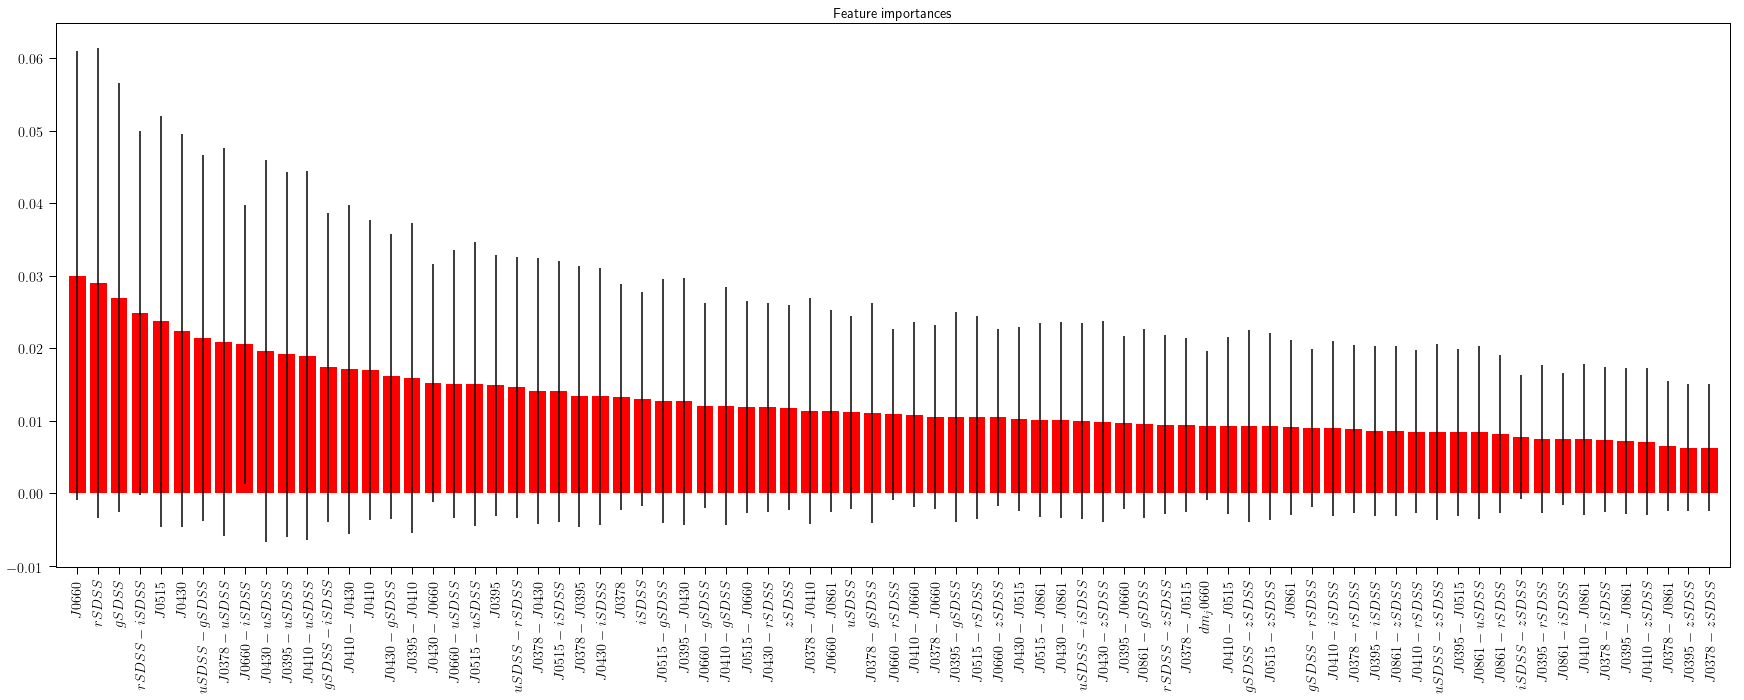

In [59]:
# get classes in integer format:

y_int = [class_to_int(x) for x in dset_original['class']]

#perform feature importances:
indices, importance, lnames = feature_importance(feat_arr_o, y_int, featnames, figsize=(30,10), n_estimators= 5000 )


Feature ranking:
1. feature 19 (0.082238): $J0378 - uSDSS$
2. feature 9 (0.073225): $J0660$
3. feature 13 (0.068669): $gSDSS$
4. feature 15 (0.067557): $rSDSS$
5. feature 8 (0.065771): $J0430$
6. feature 6 (0.061828): $J0515$
7. feature 14 (0.051894): $J0378 - J0430$
8. feature 10 (0.049217): $J0378 - J0395$
9. feature 0 (0.047687): $J0410$
10. feature 16 (0.045550): $J0378 - J0660$
11. feature 17 (0.045414): $J0378 - J0410$
12. feature 4 (0.043928): $uSDSS$
13. feature 1 (0.041647): $J0395$
14. feature 11 (0.041568): $iSDSS$
15. feature 12 (0.040911): $J0378 - J0515$
16. feature 3 (0.040091): $dm_j0660$
17. feature 2 (0.038368): $J0378$
18. feature 18 (0.033373): $J0378 - J0861$
19. feature 5 (0.031858): $zSDSS$
20. feature 7 (0.029207): $J0861$


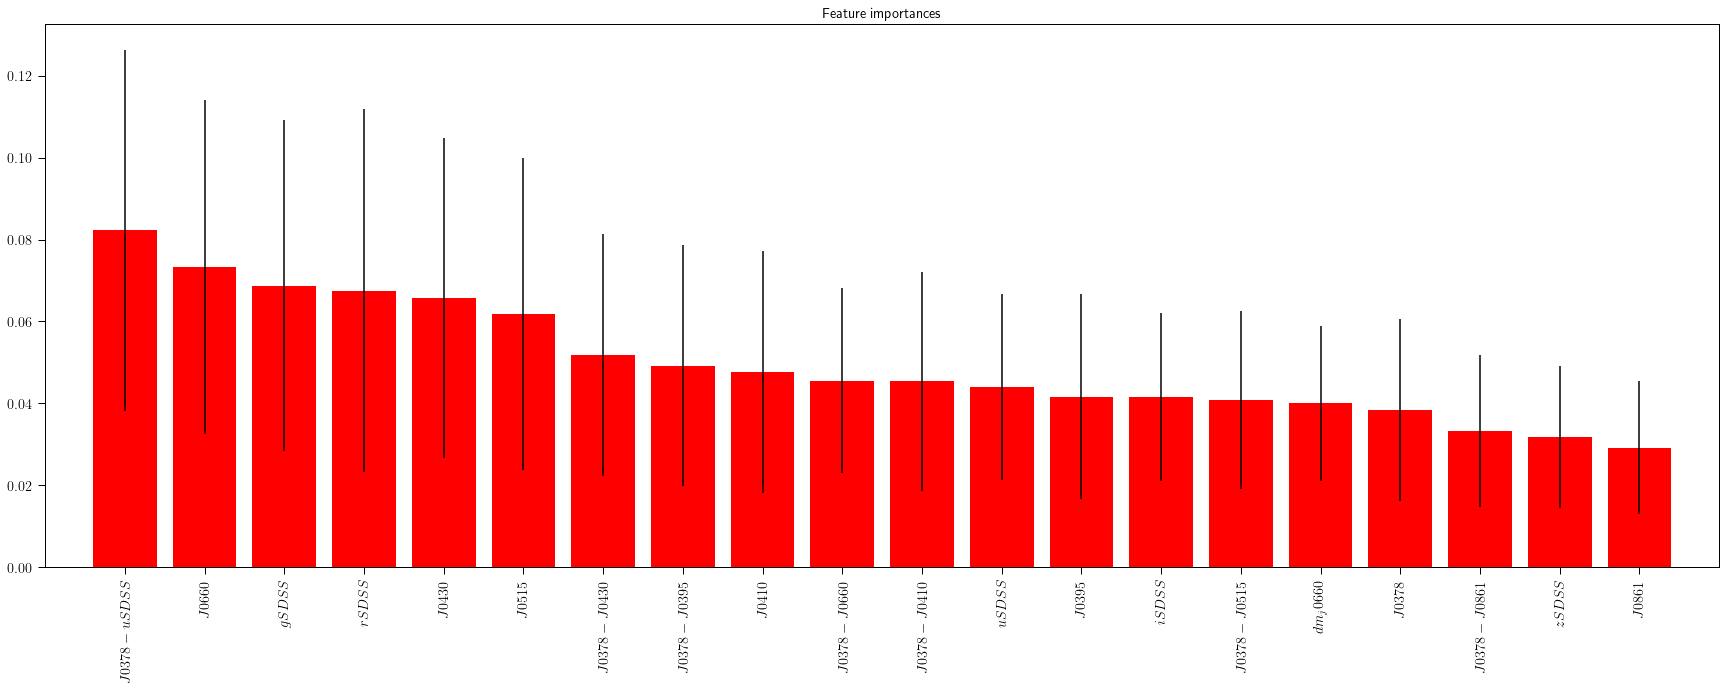

In [66]:
# Prune the features array to selecto those above a given threshold

threshold = .015 # This cut is unfortunately somewhat arbitrary

sel = np.where(importance >= threshold)[0]
important_features = indices[sel]

new_features = [np.array(x)[important_features] for x in feat_arr_o]

#Have a look at the feature importances after prunning
#indices, importance, lnames = feature_importance(new_features, y_int, 
#                              np.array(featnames)[indices[sel]], figsize=(30,10), n_estimators= 5000 )



feat_arr_opt = [np.array(x)[important_features] for x in feat_arr]
feat_test_opt= [np.array(x)[important_features] for x in feat_test]



> <ipython-input-62-9e988a7da840>(8)<module>()
      6 important_features = indices[sel]
      7 
----> 8 new_features = [x[important_features] for x in feat_arr_o]
      9 
     10 indices, importance, lnames = feature_importance(new_features, y_int, featnames[indices[sel]], figsize=(30,10), n_estimators= 5000 )

ipdb> print important_features
[ 6 10  9 76  5  4 69 19 62 46 29 38 74 34  3 47 24 44 59 53]
ipdb> feat_arr_o[0][important_features]
*** TypeError: only integer scalar arrays can be converted to a scalar index
ipdb> type(important_features)
<type 'numpy.ndarray'>
ipdb> feat_arr_o[0][list(important_features)]
*** TypeError: list indices must be integers, not list
ipdb> feat_arr_o[0][important_features]
*** TypeError: only integer scalar arrays can be converted to a scalar index
ipdb> np.array(feat_arr_o)[0][important_features]
array([18.3643951, 18.78146  , 19.10778  ,  0.18546  , 18.8479252,
       19.3471756,  1.09739  , -0.463652 , -0.2316049, -0.8579944,
       -0.4852527,

Below a resampled set is generated using `SMOTE`. This will be used as training set. However, protoypes will be drawn from the original training set, which has errors associated. However, I'm not sure of the impact of class imbalance here...

In [8]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
from collections import Counter

Xt = feat_arr_opt
y  = dset['class']

# Re-sampling using SMOTE to balance classes

def class_to_int(istr):
    if istr == 'Halpha':
        return 0
    elif istr == 'OIII+Hbeta':
        return 1
    if istr == 'OII':
        return 2
    elif istr == 'contaminant':
        return 3
    else:
        print '%s not recognised'%istr
        return -99


def class_to_int_binary(istr):
    if istr == 'OII':
        return 1
    else:
        return 0

#y_rsc = [class_to_int_binary(x) for x in Y_res]
y_int = [class_to_int_binary(x) for x in y]
y_test = [class_to_int_binary(x) for x in y]
X_res, y_res = SMOTE(sampling_strategy='not majority').fit_resample(Xt, y_int)


Scaledata = True
if Scaledata:
    print 'scaling data...',
    scaler = StandardScaler()
    scaler.fit(X_res)
    x_rsc = scaler.transform(X_res)
    x_train  = scaler.transform(Xt)
    scale_err = StandardScaler()
    scale_err.fit(err_arr)
    err_arr = scaler.transform(err_arr)
    print 'done'

outdim = len(np.unique(y_res))
print(sorted(Counter(y_res).items()))

print len(y)

scaling data... done
[(0, 558), (1, 558)]
602


In [9]:
# Choose prototypes
import multiprocessing as mp

nproc = 4  # number of parallel processes
prot_mu = [] # list of ids with all prototypes found
prot_be = []
temp_prot_id = [] #
err_t0 = 100
err_t = 99.9
nprot= 1

def get_pred(z):
    pred = [np.round(x) for x in z]
    gt3 = pred >3
    pred[gt3] = 3 # those that were rounded to 4 are set to 3
    pred = [int(x) for x in pred]
    print np.unique(pred)
    return pred


nlist = 40
npc = int(nlist / 4.)
# pick a random subset from each class
idlist = []

for i in range(2):
    sel = np.where(np.array(y_train) == i)[0]
#    print sel
    idlist.append(np.random.choice(sel, npc))

idlist = list(np.array(idlist).flatten())
print idlist              

beta_arr = 1./(2*np.array(err_arr)**2)
#idlist = list(np.random.choice(ntrain, 32))
#idlist = list(np.arange(0,ntrain))
max_prot = len(idlist)
print max_prot

all_errors = []


while ((err_t0 >= err_t) and (nprot < max_prot)) or nprot < 5: # while error improves and number of prototypes < max_prot
    err_t0 = err_t
    errors = []
    i0 = 0
    i1 = len(idlist)
    if i1 > nproc: # if there's a need to parallelise
        npp = int((i1-i0+1.0)/(nproc+0.0)) # number of prototype testings per processor
      #  print 'Number per processor:',npp

        def get_errors(idlist, _i0, _i1):
            for _it in xrange(_i0,_i1):
    #    for it in idlist:
                it = idlist[_it]
                mu_it = [x_train[it]]
                beta_it = [beta_arr[it]]
                if len(prot_mu) > 0:
                    mu_arr = list(prot_mu) ; mu_arr.append(mu_it)
                    b_arr  = list(prot_be) ; b_arr.append(beta_it)
        #            print 'length of mu_arr %d'%len(mu_arr)
                else:
                    mu_arr = [mu_it]
                    b_arr = [beta_it]

#                if it == idlist[0]:
#                     print 'prototypes found %d'%len(prot_mu)
                rbf = RBF(nfeat,mu_arr,b_arr,outdim)
                tr = rbf.train(x_rsc,y_rsc)
                pred = get_pred(rbf.test(x_rsc))
                errors.append(1 - balanced_accuracy_score(y_rsc, pred,adjusted=True))
              #  print 'Error rate: %.4f'% errors[-1]
            return errors

        def run_prot_test(ip):
            _i0 = npp*ip
            _i1 = npp*(ip+1)
            if ip == nproc-1:
                _i1 = len(idlist)  # last process is forced to reach the last sub-volume
                print 'last process goes from indices %d to %d'%(_i0,_i1)
            return get_errors(idlist, _i0, _i1)

        pool = mp.Pool(processes=nproc)
        results = [pool.apply(run_prot_test, args=(x,)) for x in range(nproc)]
#        results = [p.get() for p in res]
        print 'joining all results...'
        errors = np.concatenate([results[i] for i in range(nproc)])
        pool.terminate()
        pool.join()

    else:
        print 'not running in parallel'
        errors = get_errors(idlist, 0, len(idlist))
        
    best_prot = np.argmin(errors)
    prot_mu.append(x_train[idlist[best_prot]])
    prot_be.append(beta_arr[idlist[best_prot]])
    del idlist[best_prot]
    err_t = errors[best_prot]
    nprot = len(prot_mu)
    all_errors.append(err_t)
    print 'error:%.3f, error_0:%.3f, d_err:%.3f, len(objs):%d'%(err_t, err_t0, err_t-err_t0,len(idlist))
    

[191, 170, 216, 291, 200, 547, 450, 113, 276, 501, 38, 57, 20, 39, 29, 34, 26, 20, 36, 23]
20


NameError: global name 'y_rsc' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_errors)
plt.xlabel('Number of prototypes')
plt.ylabel('Error')
